In [49]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from scipy.stats import gaussian_kde, truncnorm
import matplotlib.pyplot as plt
from tqdm import tqdm

SIM_SIZE = 200_000
BIG_SIM_SIZE = 6_000_000
NUM_YEARS = 15

drill_costs = pd.read_excel("Analysis_Data.xlsx", header=2, sheet_name="Drilling Cost")

drill_costs.head(10)

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
0,1960-06-30,52.2,102.7,44.0,.,.,.
1,1961-06-30,51.3,94.7,45.2,-0.017241,-0.077897,0.027273
2,1962-06-30,54.2,97.1,50.8,0.05653,0.025343,0.123894
3,1963-06-30,51.8,92.4,48.2,-0.04428,-0.048404,-0.051181
4,1964-06-30,50.6,104.8,48.5,-0.023166,0.134199,0.006224
5,1965-06-30,56.6,101.9,53.1,0.118577,-0.027672,0.094845
6,1966-06-30,62.2,133.8,56.9,0.09894,0.313052,0.071563
7,1967-06-30,66.6,141.0,61.5,0.07074,0.053812,0.080844
8,1968-06-30,79.1,148.5,66.2,0.187688,0.053191,0.076423
9,1969-06-30,86.5,154.3,70.2,0.093552,0.039057,0.060423


# Phase 1: Drilling Costs

In [50]:
drill_costs = drill_costs[
    (drill_costs["Date"].dt.year >= 1991) & (drill_costs["Date"].dt.year <= 2006)
]
drill_costs

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
31,1991-06-30,346.9,506.6,441.2,0.077999,0.074899,0.200544
32,1992-06-30,362.3,426.1,357.6,0.044393,-0.158902,-0.189483
33,1993-06-30,356.6,521.2,387.7,-0.015733,0.223187,0.084172
34,1994-06-30,409.5,535.1,491.5,0.148345,0.026669,0.267733
35,1995-06-30,415.8,629.7,481.2,0.015385,0.176789,-0.020956
36,1996-06-30,341.0,616.0,541.0,-0.179894,-0.021756,0.124273
37,1997-06-30,445.6,728.6,655.6,0.306745,0.182792,0.21183
38,1998-06-30,566.0,815.6,973.2,0.270197,0.119407,0.484442
39,1999-06-30,783.0,798.4,1115.5,0.383392,-0.021089,0.146219
40,2000-06-30,593.4,756.9,1075.4,-0.242146,-0.051979,-0.035948


In [51]:
returns = drill_costs.filter(regex="^Arithmetic Return").to_numpy().flatten()
drill_costs["avg_cost"] = drill_costs.filter(regex="^U.S.").mean(axis=1)
returns, drill_costs["avg_cost"]

(array([0.07799875699192034, 0.0748992149374072, 0.2005442176870748,
        0.04439319688671097, -0.1589024871693644, -0.18948322756119668,
        -0.015732818106541507, 0.22318704529453184, 0.08417225950782987,
        0.14834548513740878, 0.026669224865694504, 0.26773278307970083,
        0.015384615384615413, 0.17678938516165207, -0.02095625635808751,
        -0.1798941798941799, -0.02175639193266642, 0.12427265170407317,
        0.3067448680351907, 0.18279220779220784, 0.21182994454713497,
        0.2701974865350089, 0.11940708207521274, 0.4844417327638804,
        0.3833922261484099, -0.021088769004413983, 0.14621866009042328,
        -0.24214559386973183, -0.05197895791583167, -0.03594800537875384,
        0.22868217054263573, 0.1844365173734972, 0.5067881718430352,
        0.21080784528871202, 0.10641383156720577, 0.03270797333991607,
        0.17501132759401905, 0.11503175723359212, 0.2340743396677422,
        0.38995469006073463, 0.5518987341772152, -0.042516100915209895,
  

In [52]:
rng = np.random.default_rng(1234)
kernel = gaussian_kde(returns)

initial_cost = drill_costs["avg_cost"].iloc[-1]

mean_return = returns.mean()
std_return = returns.std()

years_1 = 2012 - 2006
years_2 = 2015 - 2012
years_3 = 2024 - 2015

kernel.factor

0.4610539557408639

In [53]:
norm_data = []

for i in tqdm(range(BIG_SIM_SIZE), "Initial drilling costs..."):
    normal_return = rng.normal(mean_return, std_return, years_1)

    phase_2 = rng.triangular(left=-0.22, mode=-0.0917, right=-0.07, size=years_2)
    phase_3 = rng.triangular(left=0.02, mode=0.05, right=0.06, size=years_3)

    normal_phases = np.concatenate((normal_return, phase_2, phase_3))

    normal_future_vals = initial_cost * np.cumprod(1 + normal_phases)
    norm_data.append(normal_future_vals[-1])

Initial drilling costs...: 100%|██████████| 6000000/6000000 [00:32<00:00, 184661.87it/s]


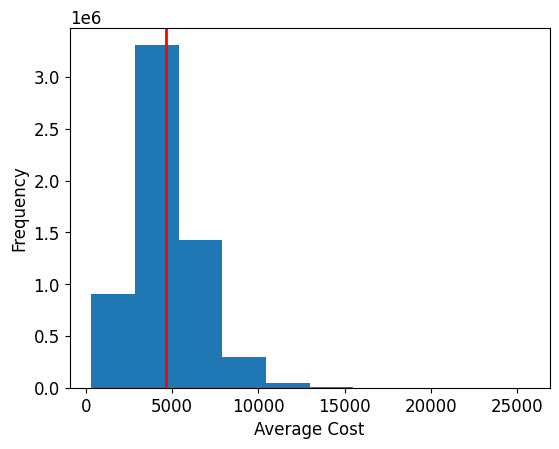

In [54]:
plt.rcParams.update({"font.size": 12})
plt.hist(norm_data)
plt.axvline(x=np.mean(norm_data), color="r", linestyle="-", linewidth=2)
plt.xlabel("Average Cost")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()

# Year 0 Expenses

In [55]:
def calculate_initial_expenses(is_dry: bool) -> np.ndarray:
    acres = rng.normal(600, 50)
    acres_cost = acres * 960
    seismic_sections = rng.normal(3, 0.35)
    seismic_sections_cost = seismic_sections * 43_000

    completion_cost = rng.normal(390_000, 50_000) if not is_dry else 0

    prof_overhead = rng.triangular(left=172_000, mode=215_000, right=279_500)
    prof_overhead = prof_overhead * NUM_YEARS if not is_dry else prof_overhead
    return acres_cost + seismic_sections_cost + prof_overhead + completion_cost


dry_well_costs = []
for _ in tqdm(range(BIG_SIM_SIZE), desc="Calculating dry costs..."):
    initial_cost = calculate_initial_expenses(is_dry=True)
    dry_well_costs.append(initial_cost)

dry_well_costs = np.array(dry_well_costs)

/var/folders/7s/plv7qn294jg_4c9nxj_69_380000gn/T/ipykernel_5669/3908440045.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])


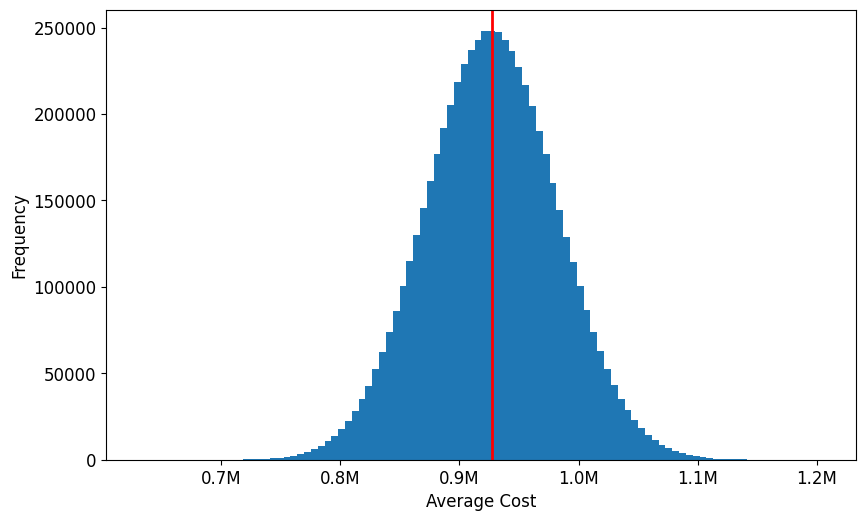

In [56]:
plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(dry_well_costs, bins=100)
ax.axvline(x=np.mean(dry_well_costs), color="r", linestyle="-", linewidth=2)
ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])
plt.xlabel("Average Cost")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()

# Production Risk

In [57]:
import scipy as sp


def standardize(x):
    x_std = (x - np.mean(x)) / np.std(x)
    return x_std


def destandardize(x_std, x):
    x_old = (x_std * np.std(x)) + np.mean(x)
    return x_old


R = np.array([[1, 0.64], [0.64, 1]])
U = sp.linalg.cholesky(R, lower=False)

decline_rate = rng.uniform(0.15, 0.32, size=BIG_SIM_SIZE)
init_production = rng.lognormal(6, 0.28, size=BIG_SIM_SIZE)

combined = np.array([standardize(decline_rate), standardize(init_production)])
combined_u = U @ combined
final_combined = np.array(
    [
        destandardize(combined_u[0], decline_rate),
        destandardize(combined_u[1], init_production),
    ]
)


def calculate_annual_production(decline_r: float, init_p: float) -> float:
    rate_year_end = init_p * np.cumprod(1 - np.repeat(decline_r, NUM_YEARS))
    rate_year_begin = np.concatenate(([init_p], rate_year_end[:-1]))
    oil_volume_year = 365 * (rate_year_begin + rate_year_end) / 2
    return oil_volume_year


calculate_annual_production(init_production[0], decline_rate[0])

array([-2.37313013e+04,  1.05051081e+07, -4.65028420e+09,  2.05853600e+12,
       -9.11249783e+14,  4.03381901e+17, -1.78564606e+20,  7.90449903e+22,
       -3.49907557e+25,  1.54893179e+28, -6.85663867e+30,  3.03522041e+33,
       -1.34359756e+36,  5.94768797e+38, -2.63285625e+41])

# Revenue Risk

In [58]:
price_projections = pd.read_excel("Analysis_Data.xlsx", header=2, sheet_name="Price Projections")
price_projections

,Year,High Oil Price,Low Oil Price,AEO2023 Reference
0,2025,167.871078,46.165466,85.233162
1,2026,166.263016,45.745247,85.255096
2,2027,167.971329,46.518333,85.532898
3,2028,166.407440,47.305279,86.264732
4,2029,166.329147,47.445293,86.738144
5,2030,167.323944,47.981407,87.188271
6,2031,169.405746,48.612011,87.748749
7,2032,168.357391,49.241779,88.512123
8,2033,170.008057,48.129913,88.937447
9,2034,172.798264,47.247337,89.608727


In [59]:
def calculate_oil_price():
    return np.array([rng.triangular(left=price_projections.loc[i, "Low Oil Price"], mode=price_projections.loc[i, "AEO2023 Reference"], right=price_projections.loc[i, "High Oil Price"]) for i in range(NUM_YEARS)])

calculate_oil_price()

array([ 84.8230374 , 101.4607085 , 108.63215947,  95.52264175,
       131.82241688, 132.73978429,  77.418036  ,  94.63888268,
       108.66725505,  85.50233276, 120.06254018,  90.64118829,
       108.47356008, 120.02135811,  64.44948618])

In [60]:
def calculate_operating_expenses(annual_production: np.ndarray, annual_revenue: np.ndarray) -> np.ndarray:
    operating_costs = rng.normal(2.25, 0.30, size=NUM_YEARS)
    annual_operating_expenses = operating_costs * annual_production + 0.046 * annual_revenue
    return annual_operating_expenses

# Main Simulation

In [61]:
net_present_values = []
for i in tqdm(range(BIG_SIM_SIZE), desc="Calculating NPV"):
    initial_cost = norm_data[i] * 1000.0 + calculate_initial_expenses(is_dry=False)
    annual_prod = calculate_annual_production(final_combined[0, i], final_combined[1, i])
    oil_prices = calculate_oil_price() 
    net_revenue_interest = rng.normal(0.75, 0.02, size=NUM_YEARS)
    annual_revenue = annual_prod * oil_prices * net_revenue_interest
    annual_operating_expenses = calculate_operating_expenses(annual_prod, annual_revenue)
    final_net_revenue = annual_revenue - annual_operating_expenses

    net_present_value = -1 * initial_cost + npf.npv(rate=0.1, values=final_net_revenue)
    net_present_values.append(net_present_value)

net_present_values = np.array(net_present_values)

Calculating NPV:   0%|          | 0/6000000 [00:00<?, ?it/s]

Calculating NPV: 100%|██████████| 6000000/6000000 [16:45<00:00, 5969.24it/s]


/var/folders/7s/plv7qn294jg_4c9nxj_69_380000gn/T/ipykernel_5669/1555021246.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])


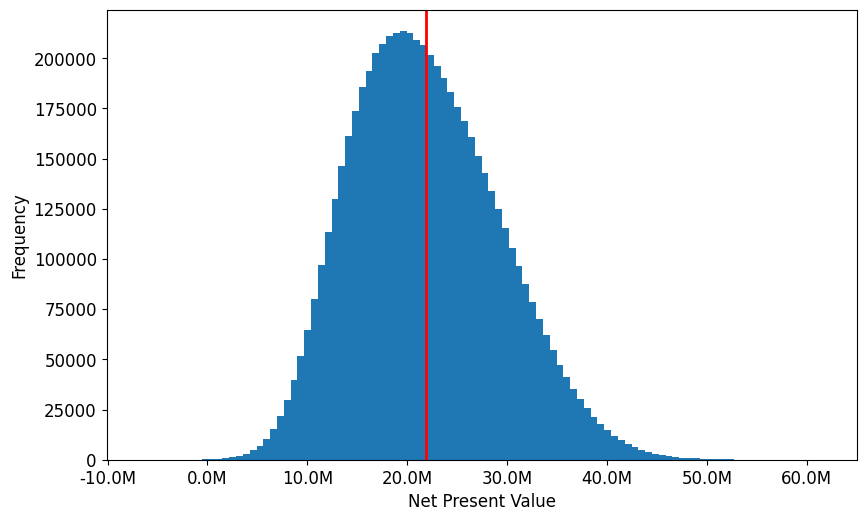

In [62]:
plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(net_present_values, bins=100)
ax.axvline(np.mean(net_present_values), color="r", linestyle="-", linewidth=2)
ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])
plt.xlabel("Net Present Value")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()

In [63]:
# VaR at 5% level
np.quantile(net_present_values, 0.05).round(3)

10789866.436

# Phase 3

In [64]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


hydrocarbon = get_truncated_normal(mean=0.99, sd=0.05, low=0.0, upp=1.0)
reservoir = get_truncated_normal(mean=0.80, sd=0.10, low=0.0, upp=1.0)

wells = []
hydro_probs = []
reservoir_probs = []

for _ in tqdm(range(SIM_SIZE), desc="Producing Wells"):
    n_wells = int(rng.uniform(10, 30))
    hydro_p = hydrocarbon.rvs(n_wells, random_state=rng)
    reservoir_p = reservoir.rvs(n_wells, random_state=rng)
    hydro_probs.extend(hydro_p)
    reservoir_probs.extend(reservoir_p)
    producing_prob = hydro_p * reservoir_p
    producing_wells_arr = [rng.binomial(n=1, p=x) for x in producing_prob]
    dry_wells = n_wells - sum(producing_wells_arr)
    wet_wells = sum(producing_wells_arr)
    wells.append({"wet": wet_wells, "dry": dry_wells})

wells = pd.DataFrame(wells)
wells["prop"] = wells["wet"] / wells.sum(axis=1)
wells.head()

Producing Wells: 100%|██████████| 200000/200000 [00:25<00:00, 7811.40it/s]


,wet,dry,prop
0,9,4,0.692308
1,22,3,0.880000
2,9,3,0.750000
3,6,4,0.600000
4,18,4,0.818182


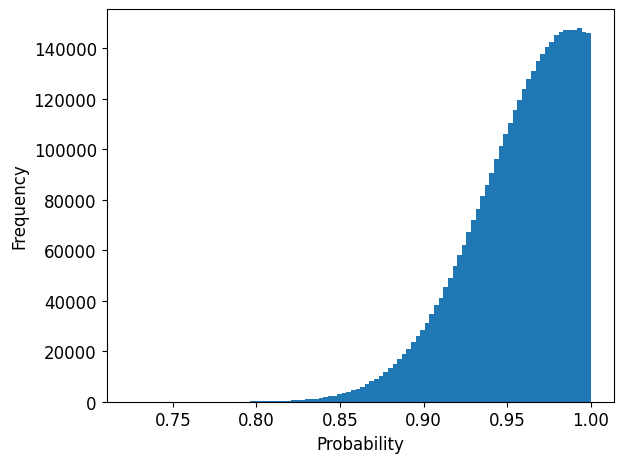

In [65]:
plt.rcParams.update({"font.size": 12})
plt.hist(hydro_probs, bins=100)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.tight_layout()
plt.savefig("hydrocarbon.png", dpi=600)
plt.show()

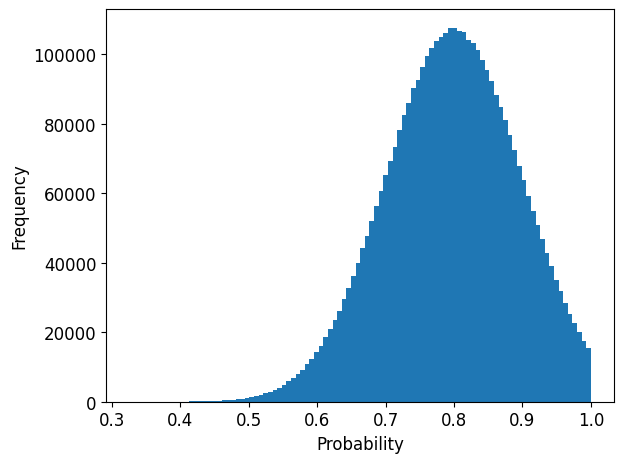

In [66]:
plt.rcParams.update({"font.size": 12})
plt.hist(reservoir_probs, bins=100)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("reservoir.png", dpi=600)
plt.show()

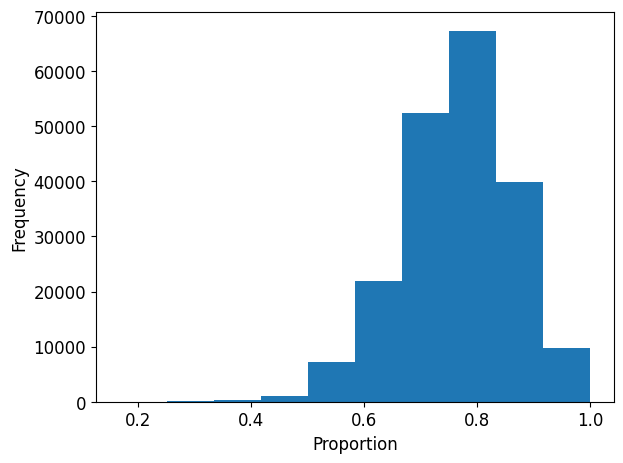

In [67]:
plt.rcParams.update({"font.size": 12})
plt.hist(wells["prop"])
plt.xlabel("Proportion")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("proportions.png", dpi=600)
plt.show()

In [68]:
# VaR at 5% level for wet well proportion
wet_value_ar = np.quantile(wells["prop"], 0.05)
wet_value_ar.round(3)

0.586

In [69]:
# Conditional VaR at 5% level for wet well proportion
wet_cvar = np.mean(wells["prop"][wells["prop"] < wet_value_ar])
wet_cvar.round(3)

0.53

In [70]:
final_npv = []

for i in tqdm(range(SIM_SIZE), desc="Calculating Overall NPV"):
    n_wet = wells.loc[i, "wet"] 
    n_dry = wells.loc[i, "dry"]
    dry_costs = rng.choice(dry_well_costs, n_dry, replace=True).sum()
    wet_npv = rng.choice(net_present_values, n_wet, replace=True).sum()
    npv = wet_npv - dry_costs 
    final_npv.append(npv)

final_npv = np.array(final_npv)

Calculating Overall NPV: 100%|██████████| 200000/200000 [00:04<00:00, 47509.32it/s]


/var/folders/7s/plv7qn294jg_4c9nxj_69_380000gn/T/ipykernel_5669/246092161.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])


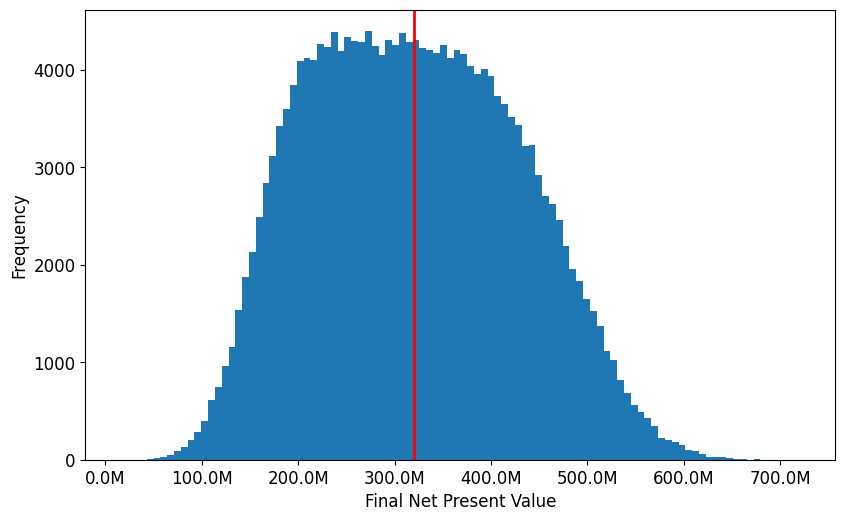

In [71]:
plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(final_npv, bins=100)
ax.axvline(np.mean(final_npv), color="r", linestyle="-", linewidth=2)
ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])
plt.xlabel("Final Net Present Value")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.savefig("final_npv.png", dpi=600)
plt.show()

In [84]:
# Expected return for final NPV
f"{np.mean(final_npv):_.3f}"

'319_695_856.779'

In [85]:
# VaR calculation at the 5% level
final_value_ar = np.quantile(final_npv, 0.05)
f"{final_value_ar:_.3f}"

'155_426_218.742'

In [86]:
# CVaR calculation at the 5% level
final_cvar = final_npv[final_npv < final_value_ar].mean()
f"{final_cvar:_.3f}"

'131_238_894.180'

# Overall Net Present Value (Potentially Deprecated)

In [87]:
def calculate_initial_expenses_vectorized(wells: list[int]) -> np.ndarray:
    acres = rng.normal(600, 50, size=len(wells))
    acres_cost = acres * 960
    seismic_sections = rng.normal(3, 0.35, size=len(wells))
    seismic_sections_cost = seismic_sections * 43_000

    completion_cost = np.where(
        wells == 1, rng.normal(390_000, 50_000, size=len(wells)), np.zeros(len(wells))
    )

    prof_overhead = rng.triangular(
        left=172_000, mode=215_000, right=279_500, size=len(wells)
    )

    # Professional overhead extends by 15 years if the well is producing
    prof_overhead = np.where(wells == 1, prof_overhead * NUM_YEARS, prof_overhead)

    return acres_cost + seismic_sections_cost + prof_overhead + completion_cost

In [88]:
# TODO: Potentially use np.where everywhere to get the correct positioned 1's and 0's
def calculate_annual_production_vectorized(wells: list[int]) -> np.ndarray:
    n_wet = np.sum(wells)
    init_production = rng.lognormal(6, 0.28, size=n_wet)
    decline_rate = rng.uniform(0.15, 0.32, size=n_wet)
    combined = np.array([standardize(init_production), standardize(decline_rate)])
    combined_u = U @ combined
    final_combined = np.array(
        [
            destandardize(combined_u[0], init_production),
            destandardize(combined_u[1], decline_rate),
        ]
    )

    rate_year_end = final_combined[0].reshape(n_wet, 1) * np.cumprod(
        1 - np.repeat(final_combined[1], NUM_YEARS).reshape(n_wet, NUM_YEARS),
        axis=1,
    )
    rate_year_begin = np.concatenate(
        (init_production.reshape(n_wet, 1), rate_year_end[:, :-1]), axis=1
    )
    oil_volume_year = 365 * (rate_year_begin + rate_year_end) / 2
    return oil_volume_year


calculate_annual_production_vectorized(3)

array([[116197.06940527,  93866.53923373,  71897.72077771,
         55070.55331142,  42181.66875418,  32309.33905504,
         24747.56027926,  18955.56386134,  14519.14440238,
         11121.03843069,   8518.23580985,   6524.60125594,
          4997.5631691 ,   3827.91785267,   2932.01998474],
       [203158.43128045, 162187.20362909, 122767.86372284,
         92929.33120382,  70343.00619164,  53246.25127479,
         40304.83523968,  30508.80963083,  23093.69234622,
         17480.8074335 ,  13232.1252031 ,  10016.07837948,
          7581.68658202,   5738.96980935,   4344.12239498],
       [145457.40619633, 103815.60027505,  84199.82943993,
         68290.42320162,  55387.07063989,  44921.78332254,
         36433.89320944,  29549.77465757,  23966.39791672,
         19437.99016266,  15765.21690396,  12786.40754261,
         10370.43884912,   8410.96309225,   6821.72675317]])

In [89]:
def calculate_operating_expenses_vectorized(annual_production: np.ndarray, annual_revenue: np.ndarray) -> np.ndarray:
    operating_costs = rng.normal(2.25, 0.30, size=(annual_production.shape[0], NUM_YEARS))
    annual_operating_expenses = operating_costs * annual_production + 0.046 * annual_revenue
    return annual_operating_expenses